![Pytorch](../../../pytorch_logo_2018.svg)

# Pytorch 高级篇（1）：生成对抗网络（Generative Adversarial Networks）

>参考代码
>
>**yunjey的 [pytorch tutorial系列](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py)**

## 生成对抗网络 学习资料

对于生成对抗网络还是很感兴趣的，可以用来生成图像, 生成的图像可以拿来当样本，hiahia。

>**论文 Arxiv地址**
>
>[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
>
>
>
>**推荐 相关博客和教程**
>
>[到底什么是生成式对抗网络GAN？By 微软亚洲研究院](https://www.msra.cn/zh-cn/news/features/gan-20170511)
>
>[莫烦视频：什么是生成对抗网络 (GAN)](https://morvanzhou.github.io/tutorials/machine-learning/torch/4-06-A-GAN/)
>
>[莫烦视频：Pytorch实现GAN](https://morvanzhou.github.io/tutorials/machine-learning/torch/4-06-GAN/)

## Pytorch 实现

### 预处理阶段

In [1]:
# 包
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
# 设备配置
torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 超参数设置
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

In [4]:
# 如果没有文件夹就创建一个文件夹
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [5]:
# 图像处理模块：transform设置
# Image processing：归一化
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
                                     std=(0.5, 0.5, 0.5))])

### MINIST 数据集

In [6]:
# 加载同时做transform预处理
mnist = torchvision.datasets.MNIST(root='../../../data/minist',
                                   train=True,
                                   transform=transform,
                                   download=True)

In [7]:
# 数据加载器：GAN中只考虑判别模型和生成模型的对抗提高，无需设置训练集和测试集
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

### 判别模型和生成模型的创建

In [8]:
# 创建判别模型
# Discriminator
D = nn.Sequential(
        nn.Linear(image_size, hidden_size), # 判别的输入时图像数据
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

In [9]:
# 创建生成模型
# Generator 
G = nn.Sequential(
        nn.Linear(latent_size, hidden_size), # 生成的输入是随机数，可以自己定义
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())

In [10]:
# 拷到计算设备上
# Device setting
D = D.to(device)
G = G.to(device)

In [11]:
# 设置损失函数和优化器
criterion = nn.BCELoss() # 二值交叉熵 Binary cross entropy loss
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [15]:
# 定义两个函数

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# 重置梯度
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

### 对抗生成训练

分两步：
1. 固定生成模型，优化判别模型
2. 固定判别模型，优化生成模型

In [16]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
            
        # 创建标签，随后会用于损失函数BCE loss的计算
        real_labels = torch.ones(batch_size, 1).to(device)  # true_label设为1，表示True
        fake_labels = torch.zeros(batch_size, 1).to(device) # fake_label设为0，表示False

        # ================================================================== #
        #                      训练判别模型                      #
        # ================================================================== #

        # 计算real_损失
        # 使用公式 BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))，来计算realimage的判别损失
        # 其中第二项永远为零，因为real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        
        # 计算fake损失
        # 生成模型根据随机输入生成fake_images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z) 
        # 使用公式 BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))，来计算fakeImage的判别损失
        # 其中第一项永远为零，因为fake_labels == 0
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 反向传播和优化
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                       训练生成模型                       #
        # ================================================================== #

        # 生成模型根据随机输入生成fake_images,然后判别模型进行判别
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # 训练生成模型，使之最大化 log(D(G(z)) ，而不是最小化 log(1-D(G(z)))
        # 具体的解释在原文第三小节最后一段有解释
        # 大致含义就是在训练初期，生成模型G还很菜，判别模型会拒绝高置信度的样本，因为这些样本与训练数据不同。
        # 这样log(1-D(G(z)))就近乎饱和，梯度计算得到的值很小，不利于反向传播和训练。
        # 换一种思路，通过计算最大化log(D(G(z))，就能够在训练初期提供较大的梯度值，利于快速收敛
        g_loss = criterion(outputs, real_labels)
        
        # 反向传播和优化
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # 在第一轮保存训练数据图像
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 每一轮保存 生成的样本（即fake_images）
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

Epoch [0/200], Step [200/600], d_loss: 0.0358, g_loss: 4.3944, D(x): 0.99, D(G(z)): 0.03
Epoch [0/200], Step [400/600], d_loss: 0.1378, g_loss: 5.3265, D(x): 0.96, D(G(z)): 0.06
Epoch [0/200], Step [600/600], d_loss: 0.2501, g_loss: 3.8991, D(x): 0.88, D(G(z)): 0.09
Epoch [1/200], Step [200/600], d_loss: 0.0795, g_loss: 5.9620, D(x): 0.97, D(G(z)): 0.05
Epoch [1/200], Step [400/600], d_loss: 0.0882, g_loss: 5.2908, D(x): 0.95, D(G(z)): 0.01
Epoch [1/200], Step [600/600], d_loss: 0.4405, g_loss: 3.4986, D(x): 0.84, D(G(z)): 0.10
Epoch [2/200], Step [200/600], d_loss: 0.9144, g_loss: 3.6864, D(x): 0.86, D(G(z)): 0.39
Epoch [2/200], Step [400/600], d_loss: 0.3320, g_loss: 3.6846, D(x): 0.89, D(G(z)): 0.09
Epoch [2/200], Step [600/600], d_loss: 0.3677, g_loss: 4.0595, D(x): 0.84, D(G(z)): 0.07
Epoch [3/200], Step [200/600], d_loss: 1.1544, g_loss: 1.7915, D(x): 0.64, D(G(z)): 0.25
Epoch [3/200], Step [400/600], d_loss: 0.2243, g_loss: 5.7187, D(x): 0.93, D(G(z)): 0.03
Epoch [3/200], Step [

Epoch [30/200], Step [600/600], d_loss: 0.4608, g_loss: 4.9773, D(x): 0.81, D(G(z)): 0.06
Epoch [31/200], Step [200/600], d_loss: 0.6517, g_loss: 3.8299, D(x): 0.83, D(G(z)): 0.14
Epoch [31/200], Step [400/600], d_loss: 0.4781, g_loss: 2.9550, D(x): 0.92, D(G(z)): 0.24
Epoch [31/200], Step [600/600], d_loss: 0.3913, g_loss: 3.8542, D(x): 0.87, D(G(z)): 0.09
Epoch [32/200], Step [200/600], d_loss: 0.5054, g_loss: 2.9697, D(x): 0.86, D(G(z)): 0.12
Epoch [32/200], Step [400/600], d_loss: 0.3362, g_loss: 3.2606, D(x): 0.91, D(G(z)): 0.14
Epoch [32/200], Step [600/600], d_loss: 0.6290, g_loss: 3.3741, D(x): 0.92, D(G(z)): 0.28
Epoch [33/200], Step [200/600], d_loss: 0.5169, g_loss: 3.8737, D(x): 0.83, D(G(z)): 0.09
Epoch [33/200], Step [400/600], d_loss: 0.4421, g_loss: 2.9322, D(x): 0.88, D(G(z)): 0.13
Epoch [33/200], Step [600/600], d_loss: 0.5625, g_loss: 3.1156, D(x): 0.86, D(G(z)): 0.17
Epoch [34/200], Step [200/600], d_loss: 0.3777, g_loss: 2.9485, D(x): 0.90, D(G(z)): 0.16
Epoch [34/

Epoch [61/200], Step [400/600], d_loss: 0.4840, g_loss: 3.0619, D(x): 0.88, D(G(z)): 0.20
Epoch [61/200], Step [600/600], d_loss: 0.3193, g_loss: 2.8534, D(x): 0.90, D(G(z)): 0.14
Epoch [62/200], Step [200/600], d_loss: 0.6673, g_loss: 3.3286, D(x): 0.82, D(G(z)): 0.23
Epoch [62/200], Step [400/600], d_loss: 0.4705, g_loss: 2.8846, D(x): 0.84, D(G(z)): 0.15
Epoch [62/200], Step [600/600], d_loss: 0.5560, g_loss: 2.0817, D(x): 0.80, D(G(z)): 0.18
Epoch [63/200], Step [200/600], d_loss: 0.6324, g_loss: 2.3931, D(x): 0.81, D(G(z)): 0.23
Epoch [63/200], Step [400/600], d_loss: 0.6408, g_loss: 3.2744, D(x): 0.75, D(G(z)): 0.15
Epoch [63/200], Step [600/600], d_loss: 0.6457, g_loss: 2.2456, D(x): 0.82, D(G(z)): 0.23
Epoch [64/200], Step [200/600], d_loss: 0.7164, g_loss: 1.9846, D(x): 0.74, D(G(z)): 0.16
Epoch [64/200], Step [400/600], d_loss: 0.7074, g_loss: 2.4294, D(x): 0.79, D(G(z)): 0.26
Epoch [64/200], Step [600/600], d_loss: 0.7245, g_loss: 2.7308, D(x): 0.83, D(G(z)): 0.28
Epoch [65/

Epoch [92/200], Step [200/600], d_loss: 0.6991, g_loss: 1.4900, D(x): 0.87, D(G(z)): 0.34
Epoch [92/200], Step [400/600], d_loss: 0.8824, g_loss: 1.8567, D(x): 0.72, D(G(z)): 0.26
Epoch [92/200], Step [600/600], d_loss: 0.7545, g_loss: 1.9790, D(x): 0.74, D(G(z)): 0.27
Epoch [93/200], Step [200/600], d_loss: 0.8425, g_loss: 2.2091, D(x): 0.77, D(G(z)): 0.30
Epoch [93/200], Step [400/600], d_loss: 0.6076, g_loss: 1.6857, D(x): 0.77, D(G(z)): 0.19
Epoch [93/200], Step [600/600], d_loss: 0.8386, g_loss: 1.7747, D(x): 0.70, D(G(z)): 0.25
Epoch [94/200], Step [200/600], d_loss: 0.6690, g_loss: 1.4644, D(x): 0.76, D(G(z)): 0.21
Epoch [94/200], Step [400/600], d_loss: 0.7112, g_loss: 2.1433, D(x): 0.74, D(G(z)): 0.15
Epoch [94/200], Step [600/600], d_loss: 0.7962, g_loss: 1.7334, D(x): 0.72, D(G(z)): 0.27
Epoch [95/200], Step [200/600], d_loss: 0.8971, g_loss: 2.2050, D(x): 0.68, D(G(z)): 0.20
Epoch [95/200], Step [400/600], d_loss: 0.6947, g_loss: 2.6301, D(x): 0.77, D(G(z)): 0.23
Epoch [95/

Epoch [122/200], Step [400/600], d_loss: 0.9066, g_loss: 1.8495, D(x): 0.64, D(G(z)): 0.19
Epoch [122/200], Step [600/600], d_loss: 1.0422, g_loss: 1.4939, D(x): 0.70, D(G(z)): 0.35
Epoch [123/200], Step [200/600], d_loss: 1.0298, g_loss: 1.5365, D(x): 0.73, D(G(z)): 0.34
Epoch [123/200], Step [400/600], d_loss: 0.7423, g_loss: 1.7237, D(x): 0.75, D(G(z)): 0.24
Epoch [123/200], Step [600/600], d_loss: 0.8463, g_loss: 1.6763, D(x): 0.76, D(G(z)): 0.31
Epoch [124/200], Step [200/600], d_loss: 0.7756, g_loss: 1.1816, D(x): 0.73, D(G(z)): 0.26
Epoch [124/200], Step [400/600], d_loss: 0.7363, g_loss: 1.8823, D(x): 0.80, D(G(z)): 0.31
Epoch [124/200], Step [600/600], d_loss: 0.8524, g_loss: 2.2753, D(x): 0.73, D(G(z)): 0.30
Epoch [125/200], Step [200/600], d_loss: 0.9161, g_loss: 1.6123, D(x): 0.71, D(G(z)): 0.29
Epoch [125/200], Step [400/600], d_loss: 0.9042, g_loss: 2.0133, D(x): 0.64, D(G(z)): 0.17
Epoch [125/200], Step [600/600], d_loss: 0.8017, g_loss: 1.4793, D(x): 0.72, D(G(z)): 0.28

Epoch [152/200], Step [600/600], d_loss: 0.8342, g_loss: 1.5227, D(x): 0.73, D(G(z)): 0.30
Epoch [153/200], Step [200/600], d_loss: 0.9768, g_loss: 1.4316, D(x): 0.65, D(G(z)): 0.28
Epoch [153/200], Step [400/600], d_loss: 0.9662, g_loss: 1.5415, D(x): 0.71, D(G(z)): 0.31
Epoch [153/200], Step [600/600], d_loss: 1.0242, g_loss: 1.7894, D(x): 0.70, D(G(z)): 0.32
Epoch [154/200], Step [200/600], d_loss: 0.9166, g_loss: 1.4075, D(x): 0.73, D(G(z)): 0.37
Epoch [154/200], Step [400/600], d_loss: 0.9261, g_loss: 2.0452, D(x): 0.70, D(G(z)): 0.29
Epoch [154/200], Step [600/600], d_loss: 1.0343, g_loss: 1.7287, D(x): 0.63, D(G(z)): 0.25
Epoch [155/200], Step [200/600], d_loss: 1.1243, g_loss: 1.5875, D(x): 0.68, D(G(z)): 0.36
Epoch [155/200], Step [400/600], d_loss: 1.0638, g_loss: 1.3523, D(x): 0.68, D(G(z)): 0.37
Epoch [155/200], Step [600/600], d_loss: 0.9444, g_loss: 1.4955, D(x): 0.67, D(G(z)): 0.30
Epoch [156/200], Step [200/600], d_loss: 0.8355, g_loss: 1.7558, D(x): 0.70, D(G(z)): 0.23

Epoch [183/200], Step [200/600], d_loss: 1.0616, g_loss: 1.3746, D(x): 0.65, D(G(z)): 0.35
Epoch [183/200], Step [400/600], d_loss: 0.9340, g_loss: 1.3568, D(x): 0.75, D(G(z)): 0.39
Epoch [183/200], Step [600/600], d_loss: 0.9345, g_loss: 1.1790, D(x): 0.66, D(G(z)): 0.29
Epoch [184/200], Step [200/600], d_loss: 0.7999, g_loss: 1.5178, D(x): 0.69, D(G(z)): 0.24
Epoch [184/200], Step [400/600], d_loss: 0.8703, g_loss: 1.6689, D(x): 0.68, D(G(z)): 0.29
Epoch [184/200], Step [600/600], d_loss: 0.9089, g_loss: 1.2437, D(x): 0.71, D(G(z)): 0.32
Epoch [185/200], Step [200/600], d_loss: 0.9887, g_loss: 1.5249, D(x): 0.65, D(G(z)): 0.30
Epoch [185/200], Step [400/600], d_loss: 0.7812, g_loss: 1.0691, D(x): 0.78, D(G(z)): 0.31
Epoch [185/200], Step [600/600], d_loss: 1.0394, g_loss: 1.7201, D(x): 0.64, D(G(z)): 0.28
Epoch [186/200], Step [200/600], d_loss: 0.8886, g_loss: 1.3273, D(x): 0.71, D(G(z)): 0.30
Epoch [186/200], Step [400/600], d_loss: 1.0213, g_loss: 1.6688, D(x): 0.71, D(G(z)): 0.35

### 结果展示

In [19]:
#导入包
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

#### real image

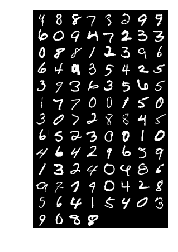

In [22]:
realPath = './samples/real_images.png'
realImage = mpimg.imread(realPath)
plt.imshow(realImage) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

#### fake image 进化过程

下图分别为第1,5,195,200轮训练生成的结果。

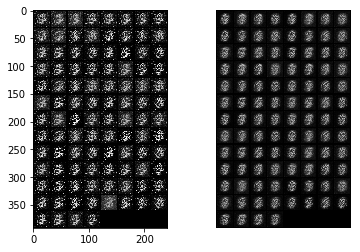

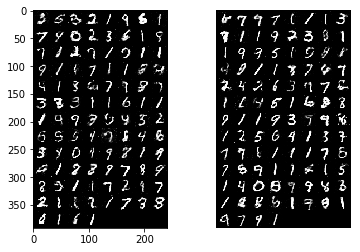

In [26]:
# 起始阶段
fakePath1 = './samples/fake_images-1.png'
fakeImg1 = mpimg.imread(fakePath1)

fakePath5 = './samples/fake_images-5.png'
fakeImg5 = mpimg.imread(fakePath5)

plt.figure()
plt.subplot(1,2,1 ) # 显示图片
plt.imshow(fakeImg1) # 显示图片
plt.subplot(1,2,2 ) # 显示图片
plt.imshow(fakeImg5) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

fakePath195 = './samples/fake_images-195.png'
fakeImg195 = mpimg.imread(fakePath195)

fakePath200 = './samples/fake_images-200.png'
fakeImg200 = mpimg.imread(fakePath200)

plt.figure()
plt.subplot(1,2,1 ) # 显示图片
plt.imshow(fakeImg195) # 显示图片
plt.subplot(1,2,2 ) # 显示图片
plt.imshow(fakeImg200) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()